In [5]:
import random
import seaborn
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from math import sqrt
from Def_funciones import *
from prophet import Prophet
from darts import TimeSeries
from matplotlib import pyplot
from multiprocess import cpu_count
from warnings import catch_warnings
from joblib import Parallel, delayed
from warnings import filterwarnings
from pandas import DataFrame, concat
from numpy import array, mean, std, median
from darts.models import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

The `LightGBM` module could not be imported. To enable LightGBM support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `CatBoost` module could not be imported. To enable CatBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


### Análisis Exploratorio:

*SHAMPOO*

Information dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   36 non-null     object 
 1   Sales   36 non-null     float64
dtypes: float64(1), object(1)
memory usage: 708.0+ bytes
None
            Sales
count   36.000000
mean   312.600000
std    148.937164
min    119.300000
25%    192.450000
50%    280.150000
75%    411.100000
max    682.000000


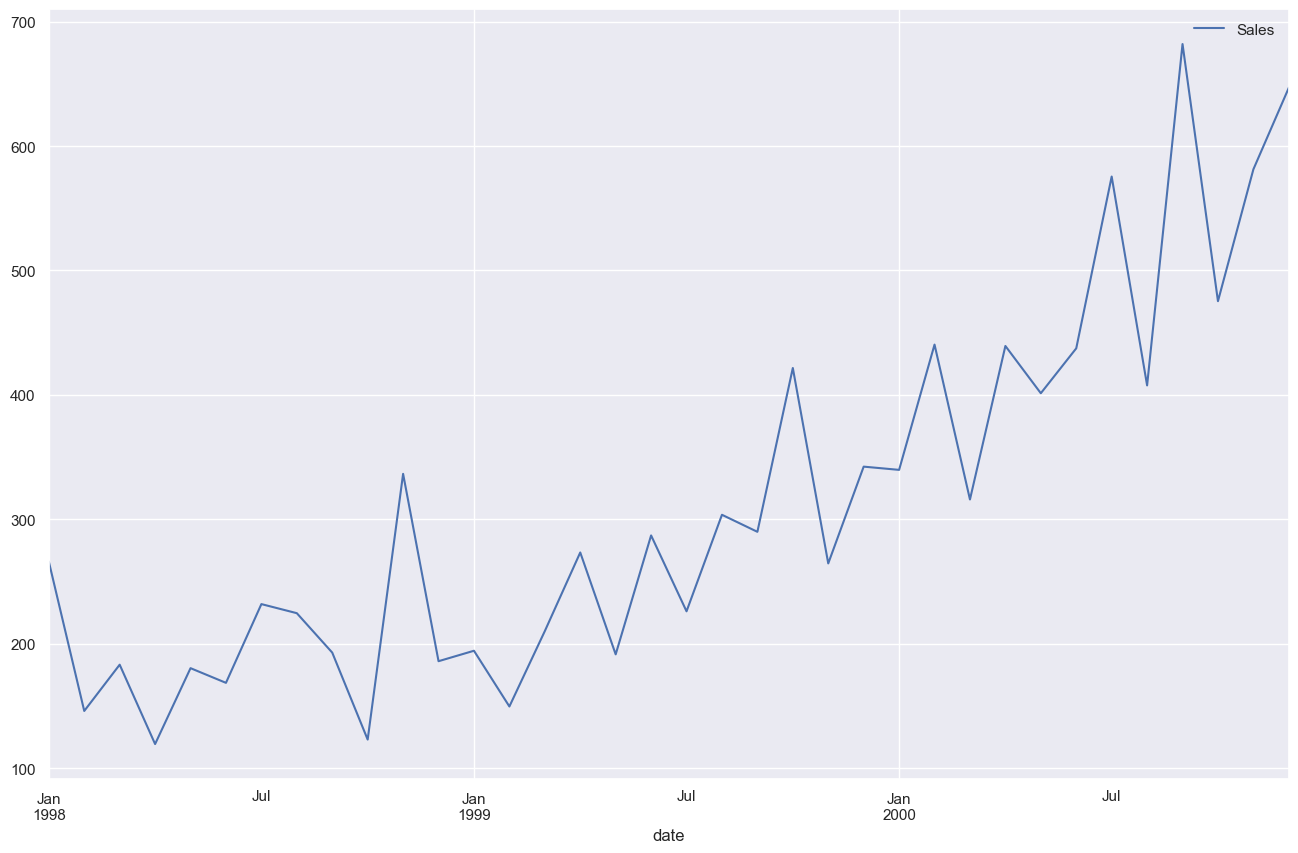

In [38]:
series = pd.read_csv('./data/shampoo.csv', header=0)
print("Information dataset")
print(series.info())
print(series.describe())

series["Year"] = [1998] * 12 + [1999] * 12 + [2000] * 12
series["Month"] = list(range(1,13)) * 3
series["Date"] = series["Month"].apply(str) + "-" + series["Year"].apply(str)
series['date']  = pd.to_datetime(series["Date"])
series = series[["date","Sales"]]
series.set_index(['date'],inplace = True)

seaborn.set()
series.plot(figsize = (16,10))
plt.savefig('shampoo.png')

*Monthly-mean-temp*

Information dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Month        240 non-null    object 
 1   Temperature  240 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.9+ KB
None
       Temperature
count   240.000000
mean     49.041250
std       8.569705
min      31.300000
25%      41.550000
50%      47.350000
75%      57.000000
max      66.500000


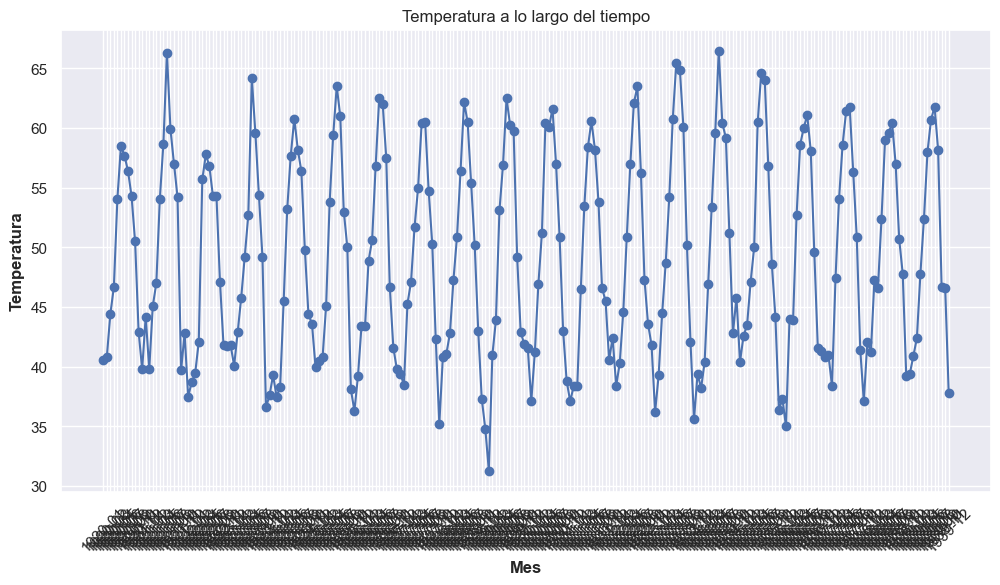

In [3]:
month_mean = pd.read_csv('./data/monthly-mean-temp.csv', header=0)

print("Information dataset")
print(month_mean.info())
print(month_mean.describe())

# Gráfica
plt.figure(figsize=(12, 6))
plt.plot(month_mean['Month'], month_mean['Temperature'], marker='o', linestyle='-', color='b')
plt.title('Temperatura a lo largo del tiempo')
plt.xlabel('Mes')
plt.ylabel('Temperatura')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

*Monthly-car-sales*

Information dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Month   108 non-null    object
 1   Sales   108 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ KB
None
              Sales
count    108.000000
mean   14595.111111
std     4525.213913
min     5568.000000
25%    11391.250000
50%    14076.000000
75%    17595.750000
max    26099.000000


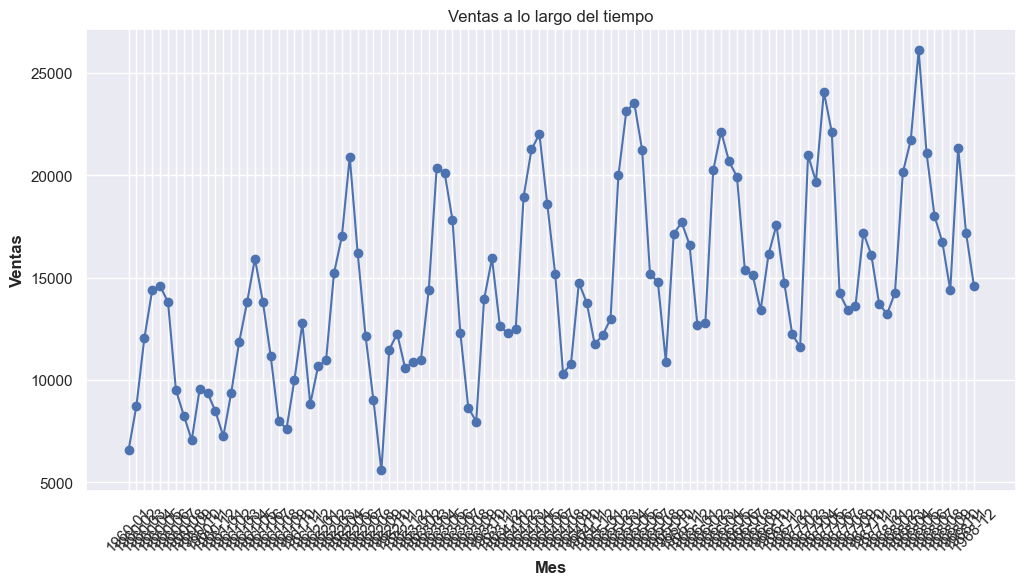

In [20]:
month_car = pd.read_csv('./data/monthly-car-sales.csv', header=0)

print("Information dataset")
print(month_car.info())
print(month_car.describe())

# Gráfica
plt.figure(figsize=(12, 6))
plt.plot(month_car['Month'], month_car['Sales'], marker='o', linestyle='-', color='b')
plt.title('Ventas a lo largo del tiempo')
plt.xlabel('Mes')
plt.ylabel('Ventas')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

*Daily-total-female-births*

Information dataset
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 1959-01-01 to 1959-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Births  365 non-null    int64
dtypes: int64(1)
memory usage: 5.7 KB
None
           Births
count  365.000000
mean    41.980822
std      7.348257
min     23.000000
25%     37.000000
50%     42.000000
75%     46.000000
max     73.000000


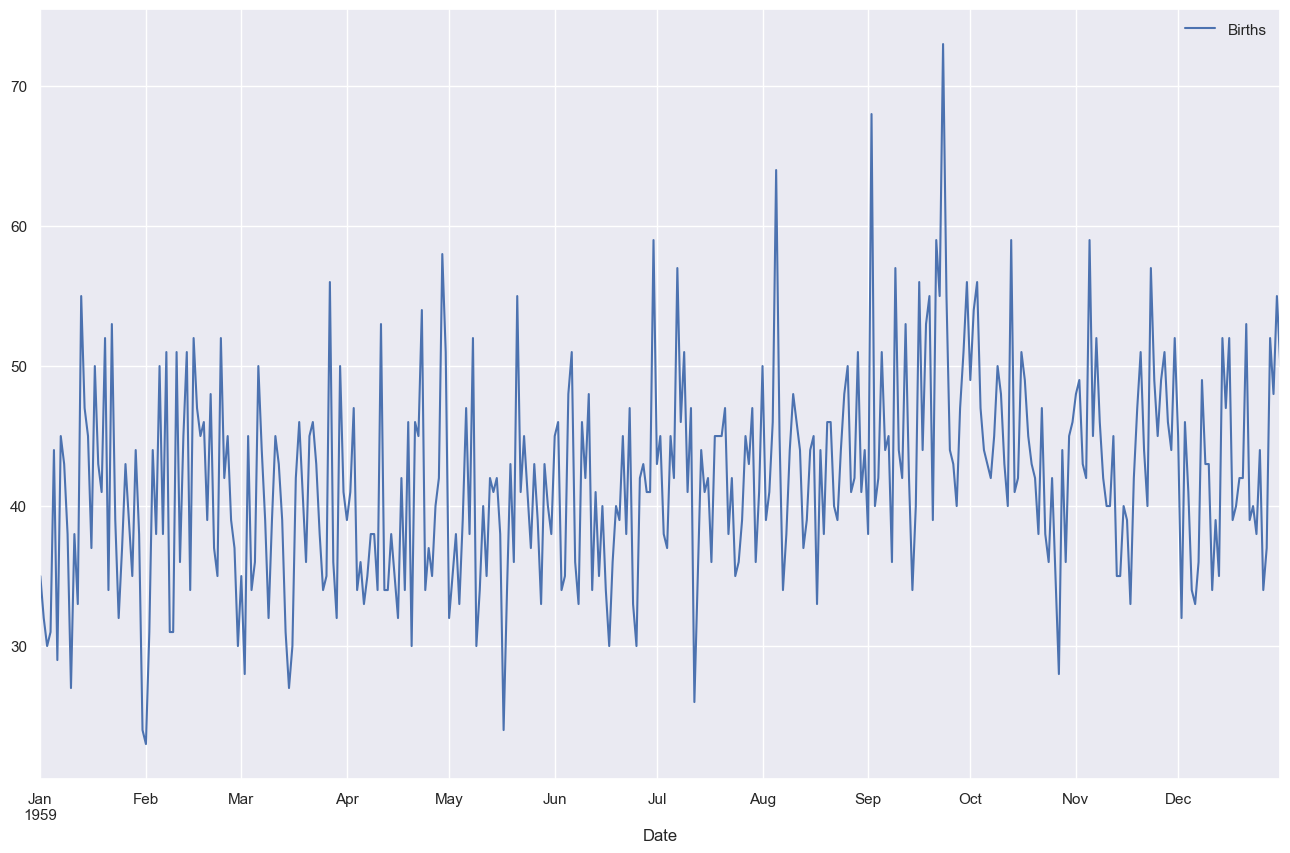

In [10]:
female_births = pd.read_csv('./data/daily-total-female-births.csv', header=0, parse_dates = ["Date"], index_col = 0)

print("Information dataset")
print(female_births.info())
print(female_births.describe())

female_births.plot(figsize=(16,10))
plt.savefig('nac_fem.png', transparent = True)

### Promedios

In [12]:
def config_simple(long_max, offsets = [1]):
    configs = []
    for i in range(1, long_max + 1):
        for t in ['mediana',"promedio"]:
            cfg = [i, t]
            configs.append(cfg)
    return configs

# prediccion de un paso por promedio
def prediccion_promedio(historia, config):
    n, tipo_promedio = config
    if tipo_promedio == 'promedio':
        return mean(historia[-n:])
    return median(historia[-n:])

def promedios(series, nombre, metodo, muestra, rmse_pro):
    # encontrar_mejor_solucion(series, nombre, metodo = "sarima")
    # def encontrar_mejor_solucion(series, nombre, metodo = "sarima", muestra = False):
    datos = series.values
    resultados = []
    n_prueba = int(len(datos) * 0.2) # porcenta usado para prueba
    long_max = len(datos) - n_prueba
    print(f"Tamaño Entrenamiento {long_max}")
    print(f"Tamaño Prueba {n_prueba}")

    # configuraciones de los modelos

    lista_cfg = config_simple(long_max)
    # muestrear algunos
    if muestra:
        lista_cfg_azar = random.sample(lista_cfg, k = 25)
        while len(resultados) < 5:
            lista_cfg_azar = random.sample(lista_cfg, k = 25)
            resultados += busqueda_malla(datos, lista_cfg_azar, n_prueba, metodo)
    else:
        # búsqueda en malla
        resultados = busqueda_malla(datos, lista_cfg, n_prueba, metodo)
        

    # ordenan las configuraciones por error, ascendente
    resultados.sort(key = lambda tup: tup[1])


    print('terminado')
    # listar las mejores 3 configuraciones
    for cfg, error, predicciones in resultados[:3]:
        print(cfg, error ,"AA")
        rsme_pro = error
    # desplegar
    entreno, prueba = division_entreno_prueba(datos, n_prueba)
    prediccion = pd.DataFrame(list(entreno.flatten()) + resultados[0][2])
    ax = pd.DataFrame(datos).plot(label = "Original") # Datos originales
    prediccion.plot(ax = ax, alpha = .7, figsize = (14,7))

    plt.savefig(f"{nombre}_{metodo}.png", transparent = True)
    plt.show()

*SHAMPOO*

Tamaño Entrenamiento 29
Tamaño Prueba 7
58
terminado
[3, 'promedio'] 111.5106230258761 AA
[2, 'mediana'] 113.1503361525213 AA
[2, 'promedio'] 113.1503361525213 AA


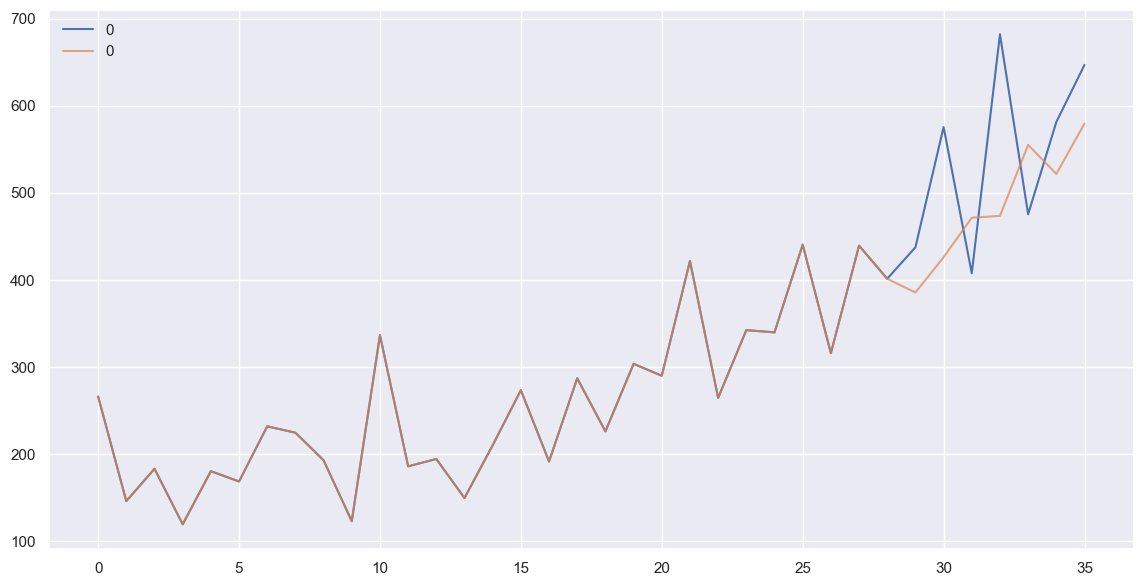

In [39]:
series = pd.read_csv('./data/shampoo.csv', header = 0, index_col = 0)
nombre="shampoo"
metodo = "promedio"
muestra = False
rsme_pro_shampo = 0

promedios(series, nombre, metodo, muestra, rsme_pro_shampo)


*Monthly-mean-temp*

Tamaño Entrenamiento 192
Tamaño Prueba 48
 > Modelo[1, 'mediana'] 5.144
 > Modelo[1, 'promedio'] 5.144
 > Modelo[2, 'mediana'] 6.595
 > Modelo[2, 'promedio'] 6.595
 > Modelo[3, 'mediana'] 8.336
 > Modelo[3, 'promedio'] 8.144
 > Modelo[4, 'mediana'] 9.714
 > Modelo[4, 'promedio'] 9.405
 > Modelo[5, 'mediana'] 11.176
 > Modelo[5, 'promedio'] 10.343
 > Modelo[6, 'mediana'] 11.964
 > Modelo[6, 'promedio'] 10.946
 > Modelo[7, 'promedio'] 11.168
 > Modelo[8, 'promedio'] 11.018
 > Modelo[7, 'mediana'] 12.716
 > Modelo[9, 'promedio'] 10.560
 > Modelo[11, 'promedio'] 9.113
 > Modelo[10, 'promedio'] 9.887
 > Modelo[8, 'mediana'] 12.263
 > Modelo[9, 'mediana'] 11.490
 > Modelo[13, 'promedio'] 7.861
 > Modelo[10, 'mediana'] 10.721
 > Modelo[12, 'mediana'] 8.412
 > Modelo[12, 'promedio'] 8.384
 > Modelo[14, 'promedio'] 7.655
 > Modelo[11, 'mediana'] 9.883 > Modelo[13, 'mediana'] 7.341

 > Modelo[15, 'promedio'] 7.770
 > Modelo[16, 'promedio'] 8.130
 > Modelo[14, 'mediana'] 7.133
 > Modelo[17, 'prom

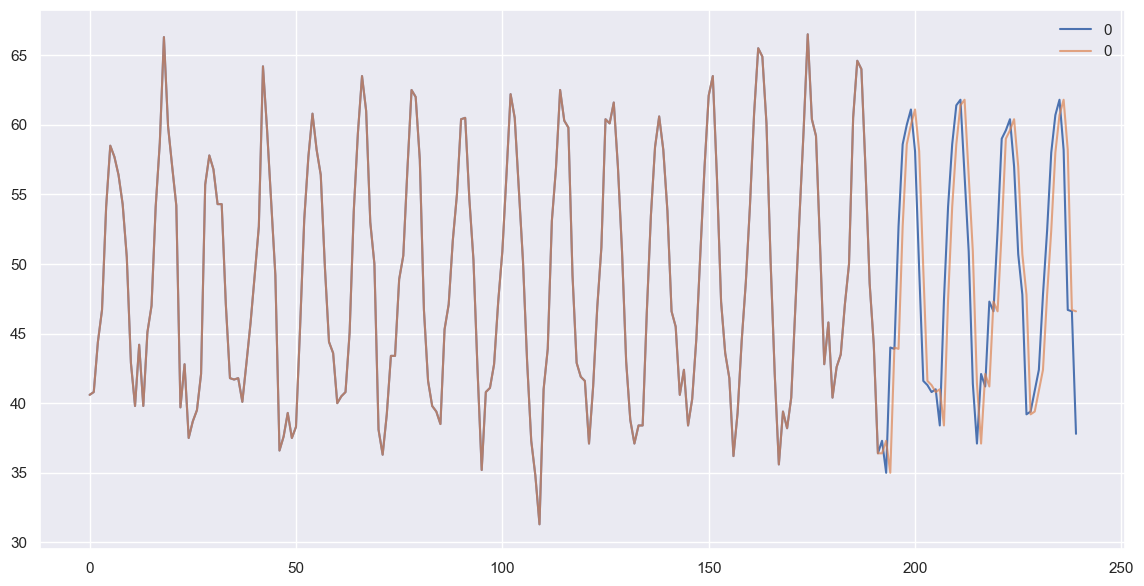

In [6]:
series = pd.read_csv('./data/monthly-mean-temp.csv', header = 0, index_col = 0)
nombre="monthly-mean-temp"
metodo = "promedio"
muestra = False
rsme_pro_mmt = 0

promedios(series, nombre, metodo, muestra, rsme_pro_mmt)

*Monthly-car-sales*

Tamaño Entrenamiento 87
Tamaño Prueba 21
 > Modelo[1, 'mediana'] 3647.539
 > Modelo[1, 'promedio'] 3647.539
 > Modelo[2, 'mediana'] 4100.970
 > Modelo[2, 'promedio'] 4100.970
 > Modelo[3, 'mediana'] 4657.297
 > Modelo[3, 'promedio'] 4570.022
 > Modelo[4, 'mediana'] 4962.490
 > Modelo[4, 'promedio'] 4800.520
 > Modelo[5, 'mediana'] 5322.483
 > Modelo[5, 'promedio'] 4659.462
 > Modelo[6, 'mediana'] 5036.207
 > Modelo[7, 'promedio'] 4474.116
 > Modelo[6, 'promedio'] 4530.800
 > Modelo[7, 'mediana'] 5016.972
 > Modelo[8, 'promedio'] 4547.901
 > Modelo[9, 'promedio'] 4576.610
 > Modelo[8, 'mediana'] 4852.275
 > Modelo[10, 'promedio'] 4457.819
 > Modelo[9, 'mediana'] 4975.221
 > Modelo[11, 'promedio'] 4212.172
 > Modelo[10, 'mediana'] 4935.237
 > Modelo[12, 'promedio'] 3923.195
 > Modelo[11, 'mediana'] 4907.447
 > Modelo[12, 'mediana'] 4421.740
 > Modelo[13, 'promedio'] 3782.176
 > Modelo[14, 'promedio'] 3768.610
 > Modelo[13, 'mediana'] 4159.888
 > Modelo[15, 'promedio'] 3893.995
 > Modelo[

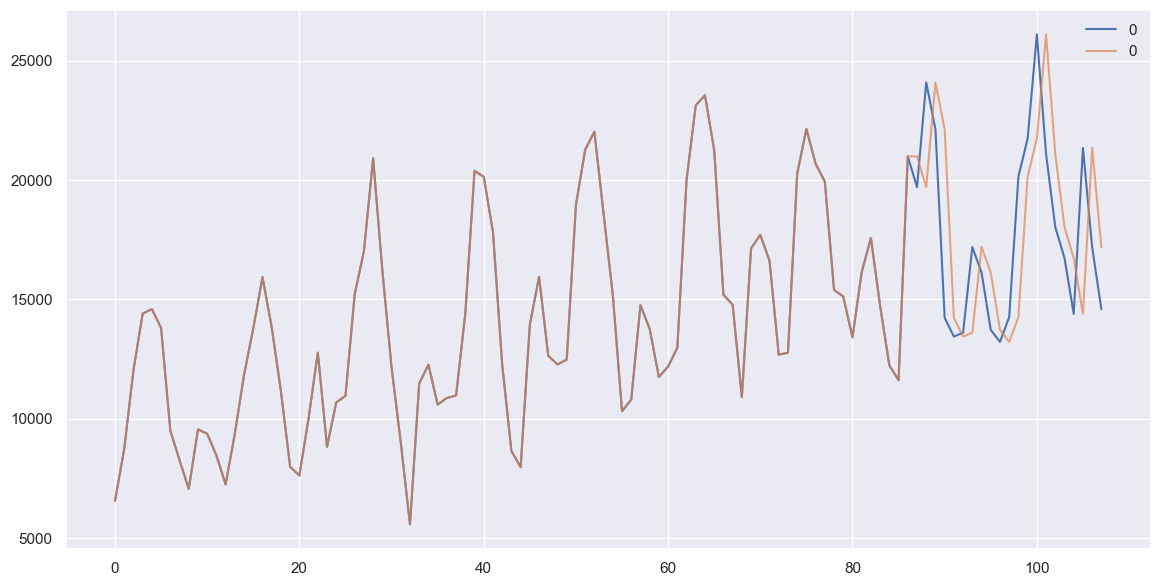

In [21]:
series = pd.read_csv('./data/monthly-car-sales.csv', header = 0, index_col = 0)
nombre="monthly-car-sales"
metodo = "promedio"
muestra = False
rsme_pro_mcs = 0

promedios(series, nombre, metodo, muestra, rsme_pro_mcs)

*Daily-total-female-births*

Tamaño Entrenamiento 292
Tamaño Prueba 73
584
terminado
[192, 'mediana'] 6.375251808080867 AA
[191, 'mediana'] 6.380621346477417 AA
[153, 'mediana'] 6.394561045052593 AA


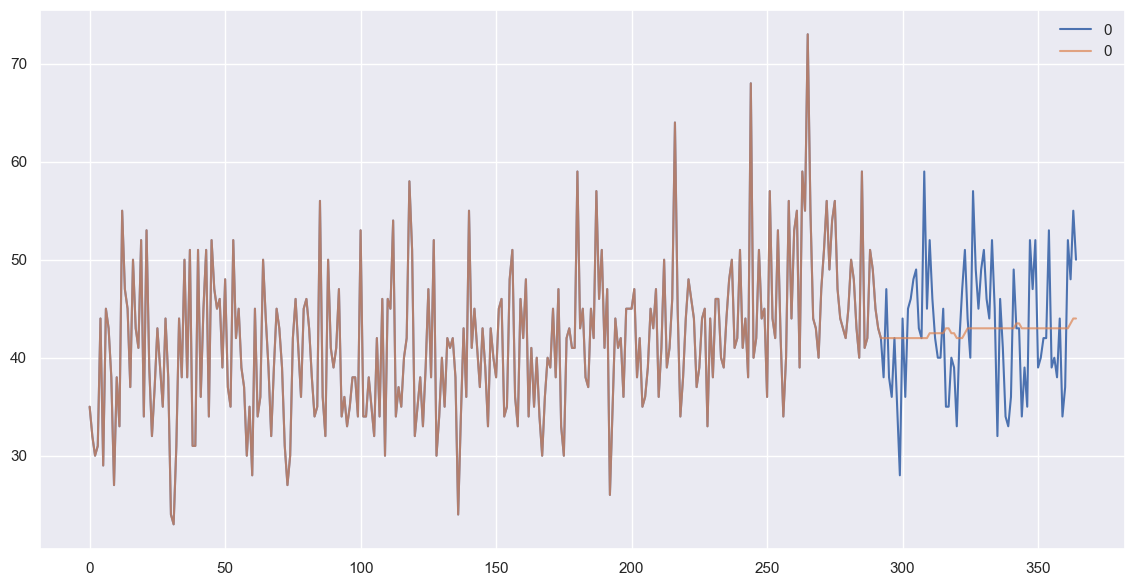

In [13]:
series = pd.read_csv('./data/daily-total-female-births.csv', header = 0, index_col = 0)
nombre="nac_fem"
metodo = "promedio"
muestra = False
rsme_pro_nac_fem = 0

promedios(series, nombre, metodo, muestra, rsme_pro_nac_fem)

### SARIMA

In [17]:
def prediccion_sarima(historia, config):
    orden, orden_estacional, tendencia = config
    # definir el modelo
    modelo = SARIMAX(historia, order = orden, seasonal_order = orden_estacional, trend = tendencia,
      enforce_stationarity = False, enforce_invertibility = False)
    # ajustar el model con los datos
    modelo_ajustado = modelo.fit(disp = False)
    # hacer la predicción de un paso
    yhat = modelo_ajustado.predict(len(historia), len(historia))
    return yhat[0]

def config_sarima(estacional = [0]):
    modelos = []
    # definir las listas de configuración
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct'] 
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = estacional
    # crear instancias de configuración
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    modelos.append(cfg)
    return modelos

def sarima(series, nombre, metodo, muestra, rsme_sar):
    # encontrar_mejor_solucion(series, nombre, metodo = "sarima")
    # def encontrar_mejor_solucion(series, nombre, metodo = "sarima", muestra = False):
    datos = series.values
    resultados = []
    n_prueba = int(len(datos) * 0.2) # porcenta usado para prueba
    long_max = len(datos) - n_prueba
    print(f"Tamaño Entrenamiento {long_max}")
    print(f"Tamaño Prueba {n_prueba}")

    # configuraciones de los modelos

    lista_cfg = config_sarima()
    # muestrear algunos
    if muestra:
        lista_cfg_azar = random.sample(lista_cfg, k = 25)
        while len(resultados) < 5:
            lista_cfg_azar = random.sample(lista_cfg, k = 25)
            resultados += busqueda_malla(datos, lista_cfg_azar, n_prueba, metodo)
    else:
        # búsqueda en malla
        resultados = busqueda_malla(datos, lista_cfg, n_prueba, metodo)
        

    # ordenan las configuraciones por error, ascendente
    resultados.sort(key = lambda tup: tup[1])


    print('terminado')
    # listar las mejores 3 configuraciones
    for cfg, error, predicciones in resultados[:3]:
        print(cfg, error)
        rsme_sar = error

    # desplegar
    entreno, prueba = division_entreno_prueba(datos, n_prueba)
    prediccion = pd.DataFrame(list(entreno.flatten()) + resultados[0][2])
    ax = pd.DataFrame(datos).plot(label = "Original") # Datos originales
    prediccion.plot(ax = ax, alpha = .7, figsize = (14,7))

    plt.savefig(f"{nombre}_{metodo}.png", transparent = True)
    plt.show()



*Shampoo*

Tamaño Entrenamiento 29
Tamaño Prueba 7
72
terminado
[(0, 1, 2), (0, 0, 0, 0), 'c'] 69.40192219899937
[(1, 0, 2), (0, 0, 0, 0), 't'] 70.12720363800007
[(1, 1, 1), (0, 0, 0, 0), 'ct'] 72.00875467562055


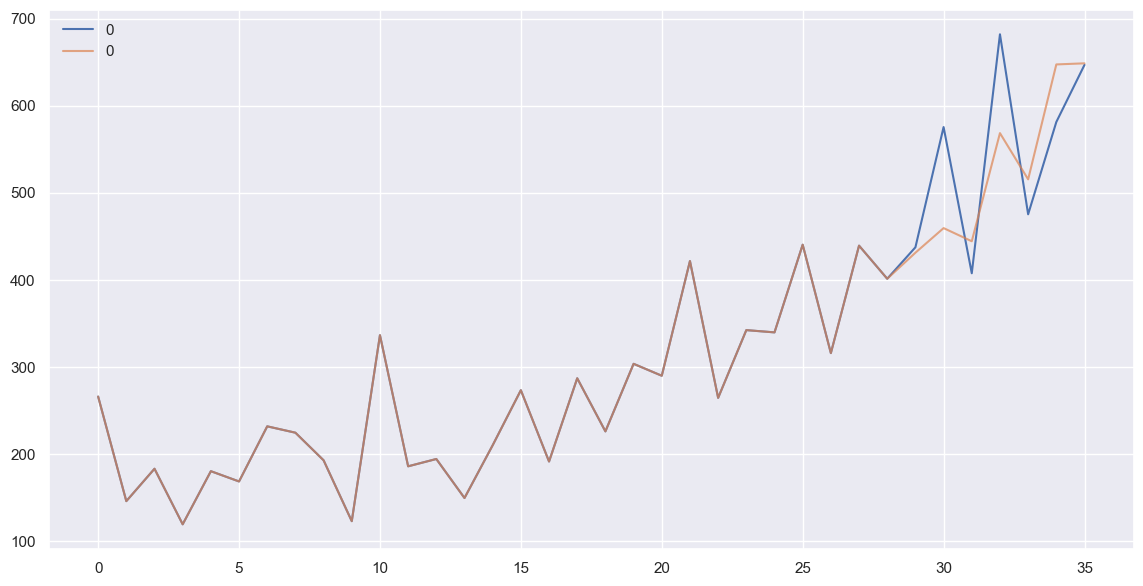

In [40]:
series = pd.read_csv('./data/shampoo.csv', header = 0, index_col = 0)
nombre= "shampoo"
metodo = "sarima"
muestra = False
rsme_sar_shampoo = 0

sarima(series, nombre, metodo, muestra, rsme_sar_shampoo)

*Monthly-mean-temp*

Tamaño Entrenamiento 192
Tamaño Prueba 48
 > Modelo[(0, 0, 0), (0, 0, 0, 0), 'n'] 50.042
 > Modelo[(0, 1, 0), (0, 0, 0, 0), 'n'] 5.144
 > Modelo[(0, 0, 0), (0, 0, 0, 0), 'c'] 8.366
 > Modelo[(0, 1, 0), (0, 0, 0, 0), 'c'] 5.156
 > Modelo[(0, 0, 0), (0, 0, 0, 0), 't'] 25.947
 > Modelo[(0, 1, 0), (0, 0, 0, 0), 't'] 5.181
 > Modelo[(0, 0, 0), (0, 0, 0, 0), 'ct'] 8.419
 > Modelo[(0, 1, 1), (0, 0, 0, 0), 'n'] 4.912
 > Modelo[(0, 1, 0), (0, 0, 0, 0), 'ct'] 5.196
 > Modelo[(0, 0, 1), (0, 0, 0, 0), 'c'] 5.757
 > Modelo[(0, 0, 1), (0, 0, 0, 0), 'n'] 26.014
 > Modelo[(0, 0, 1), (0, 0, 0, 0), 't'] 14.214
 > Modelo[(0, 1, 2), (0, 0, 0, 0), 'n'] 4.429
 > Modelo[(0, 1, 1), (0, 0, 0, 0), 'c'] 4.924
 > Modelo[(0, 0, 2), (0, 0, 0, 0), 'c'] 4.718
 > Modelo[(0, 0, 1), (0, 0, 0, 0), 'ct'] 5.799
 > Modelo[(0, 1, 1), (0, 0, 0, 0), 't'] 4.947
 > Modelo[(1, 0, 0), (0, 0, 0, 0), 'n'] 5.150
 > Modelo[(0, 0, 2), (0, 0, 0, 0), 'n'] 17.090
 > Modelo[(0, 1, 1), (0, 0, 0, 0), 'ct'] 4.960
 > Modelo[(0, 1, 2), (0, 0, 0

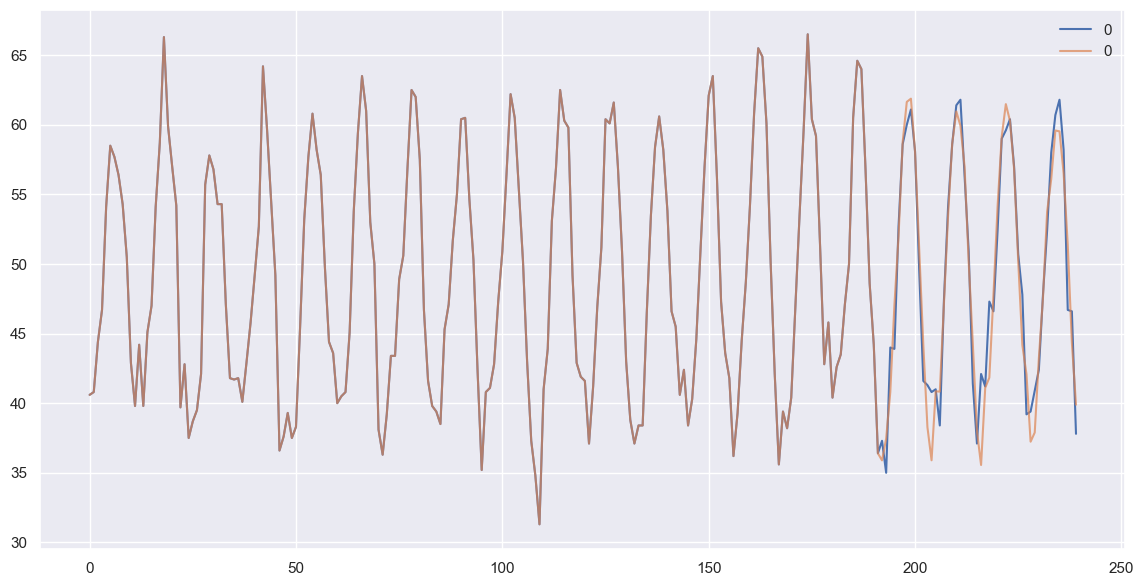

In [9]:
series = pd.read_csv('./data/monthly-mean-temp.csv', header = 0, index_col = 0)
nombre="monthly-mean-temp"
metodo = "sarima"
muestra = False
rsme_sar_mmt = 0

sarima(series, nombre, metodo, muestra, rsme_sar_mmt)

*Monthly car sales*

Tamaño Entrenamiento 87
Tamaño Prueba 21
 > Modelo[(0, 0, 0), (0, 0, 0, 0), 'n'] 18156.633
 > Modelo[(0, 1, 0), (0, 0, 0, 0), 'n'] 3647.539
 > Modelo[(0, 0, 0), (0, 0, 0, 0), 'c'] 5200.419
 > Modelo[(0, 0, 0), (0, 0, 0, 0), 't'] 7005.922
 > Modelo[(0, 0, 0), (0, 0, 0, 0), 'ct'] 3967.973
 > Modelo[(0, 1, 0), (0, 0, 0, 0), 'c'] 3678.378
 > Modelo[(0, 1, 0), (0, 0, 0, 0), 't'] 3716.156
 > Modelo[(0, 1, 0), (0, 0, 0, 0), 'ct'] 3723.536
 > Modelo[(0, 1, 1), (0, 0, 0, 0), 'n'] 3839.616
 > Modelo[(0, 0, 1), (0, 0, 0, 0), 'n'] 9522.492
 > Modelo[(0, 0, 1), (0, 0, 0, 0), 'c'] 3876.732
 > Modelo[(0, 1, 1), (0, 0, 0, 0), 'c'] 3859.975
 > Modelo[(0, 1, 1), (0, 0, 0, 0), 't'] 3908.055
 > Modelo[(0, 0, 2), (0, 0, 0, 0), 'n'] 7727.509
 > Modelo[(0, 0, 1), (0, 0, 0, 0), 't'] 4882.865
 > Modelo[(0, 1, 1), (0, 0, 0, 0), 'ct'] 3934.109
 > Modelo[(0, 0, 2), (0, 0, 0, 0), 'c'] 3585.680
 > Modelo[(0, 0, 1), (0, 0, 0, 0), 'ct'] 3395.622
 > Modelo[(1, 0, 0), (0, 0, 0, 0), 'n'] 3635.403
 > Modelo[(0, 1, 2), (0

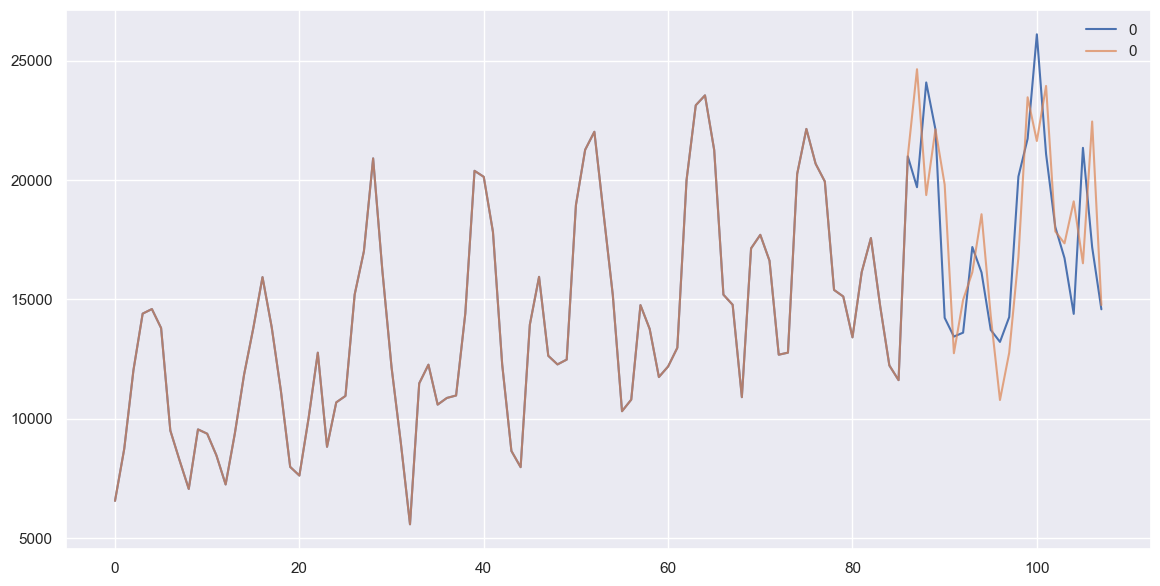

In [22]:
series = pd.read_csv('./data/monthly-car-sales.csv', header = 0, index_col = 0)
nombre="monthly-car-sales"
metodo = "sarima"
muestra = False
rsme_sar_mcs = 0

sarima(series, nombre, metodo, muestra, rsme_sar_mcs)

*Daily-total-female-births*

Tamaño Entrenamiento 292
Tamaño Prueba 73
72
terminado
[(2, 0, 0), (0, 0, 0, 0), 'c'] 6.229422863189241
[(1, 0, 0), (0, 0, 0, 0), 'c'] 6.271032076892793
[(0, 0, 2), (0, 0, 0, 0), 'c'] 6.272134388166806


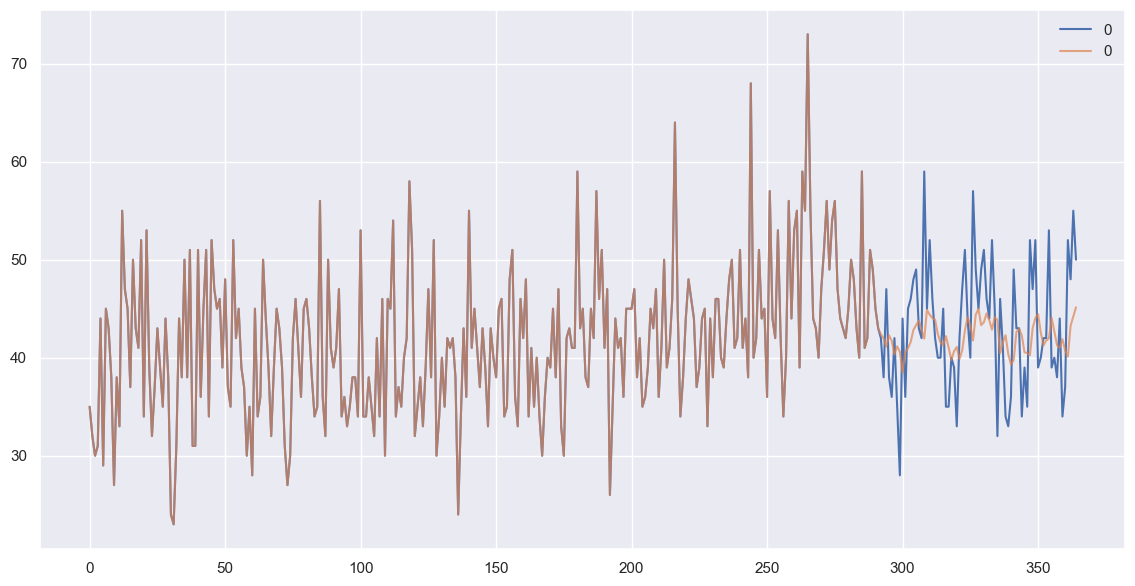

In [18]:
series = pd.read_csv('./data/daily-total-female-births.csv', header = 0, index_col = 0)
nombre="nac_fem"
metodo = "sarima"
muestra = False
rsme_sar_nac_fem = 0

sarima(series, nombre, metodo, muestra, rsme_sar_nac_fem)

### Alisamiento Exponencial

*SHAMPOO*

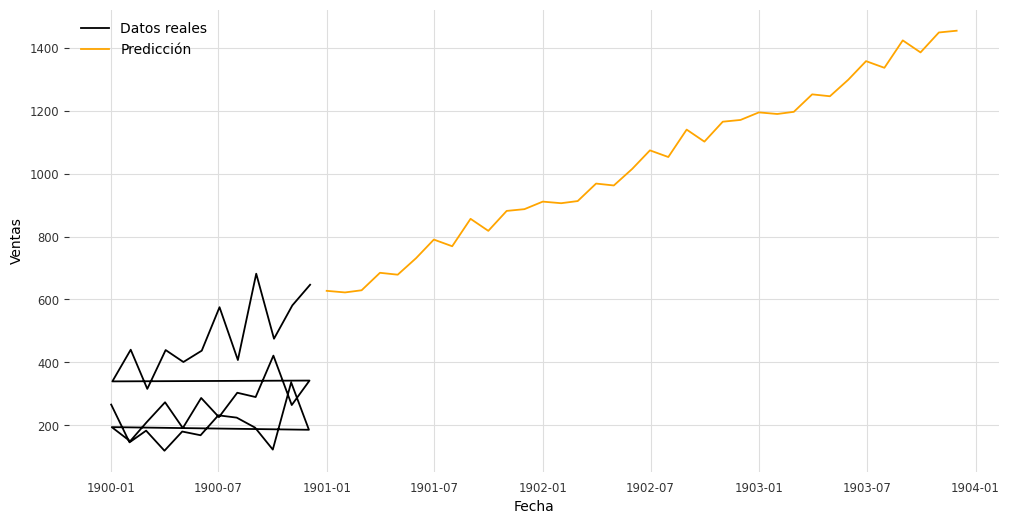

In [15]:
datos = pd.read_csv('./data/shampoo.csv', delimiter=",")
# Agrega un año ficticio y convierte las fechas en el formato correcto "YYYY-MM"
# datos['Month'] = pd.to_datetime('2023-' + datos['Month'], format='%Y-%d-%m')
datos['Month'] = pd.to_datetime(datos['Month'], format='%d-%m')
datos['Sales'] = datos['Sales'].astype(float)

modelo = ExponentialSmoothing(datos['Sales'], trend='add', seasonal='add', seasonal_periods=12)
modelo_fit = modelo.fit()

prediccion = modelo_fit.forecast(steps=36)  # Ajusta el número de pasos según tus necesidades

# Visualiza los datos y las predicciones
plt.figure(figsize=(12, 6))
plt.plot(datos['Month'], datos['Sales'], label='Datos reales')
plt.plot(pd.date_range(start=datos['Month'].max(), periods=36, freq='M'), prediccion, label='Predicción', color='orange')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()


*Daily-total-female-births*

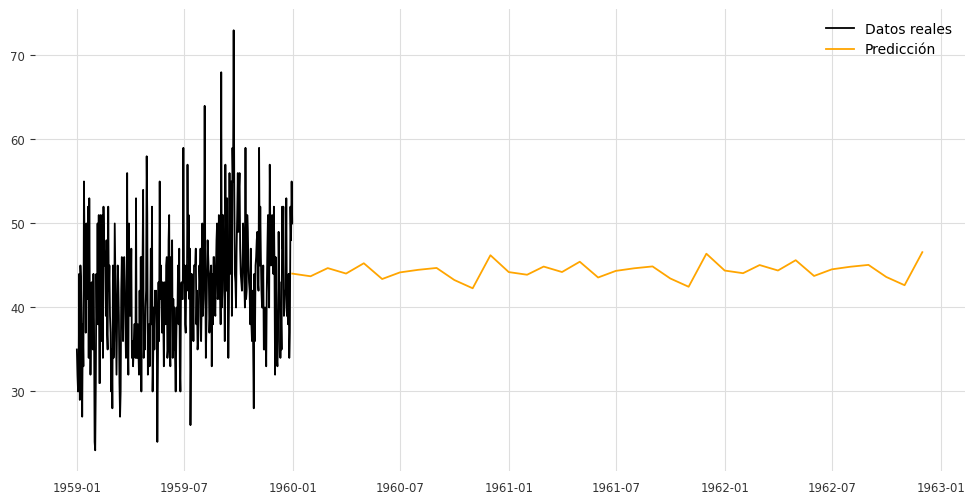

In [8]:
datos = pd.read_csv('./data/daily-total-female-births.csv', delimiter=",")

datos['Date'] = pd.to_datetime(datos['Date'], format='%Y-%m-%d')
datos['Births'] = datos['Births'].astype(float)

# Ajusta el modelo de suavización exponencial
modelo = ExponentialSmoothing(datos['Births'], trend='add', seasonal='add', seasonal_periods=12)
modelo_fit = modelo.fit()

# Realiza predicciones
prediccion = modelo_fit.forecast(steps=36)  # Ajusta el número de pasos según tus necesidades

# Visualiza los datos y las predicciones
plt.figure(figsize=(12, 6))
plt.plot(datos['Date'], datos['Births'], label='Datos reales')
plt.plot(pd.date_range(start=datos['Date'].max(), periods=36, freq='M'), prediccion, label='Predicción', color='orange')
plt.legend()
plt.show()

*Monthly-car-sales*

c:\Users\Contreras GP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


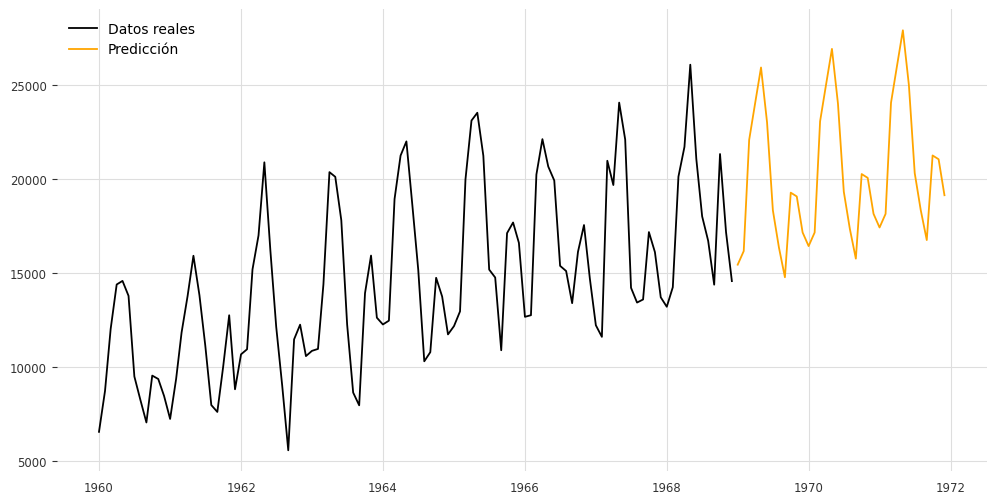

In [11]:
datos = pd.read_csv('./data/monthly-car-sales.csv', delimiter=",")

datos['Month'] = pd.to_datetime(datos['Month'], format='%Y-%m')
datos['Sales'] = datos['Sales'].astype(float)

# Ajusta el modelo de suavización exponencial
modelo = ExponentialSmoothing(datos['Sales'], trend='add', seasonal='add', seasonal_periods=12)
modelo_fit = modelo.fit()

# Realiza predicciones
prediccion = modelo_fit.forecast(steps=36)  # Ajusta el número de pasos según tus necesidades

# Visualiza los datos y las predicciones
plt.figure(figsize=(12, 6))
plt.plot(datos['Month'], datos['Sales'], label='Datos reales')
plt.plot(pd.date_range(start=datos['Month'].max(), periods=36, freq='M'), prediccion, label='Predicción', color='orange')
plt.legend()
plt.show()

*Monthly-mean-temp*

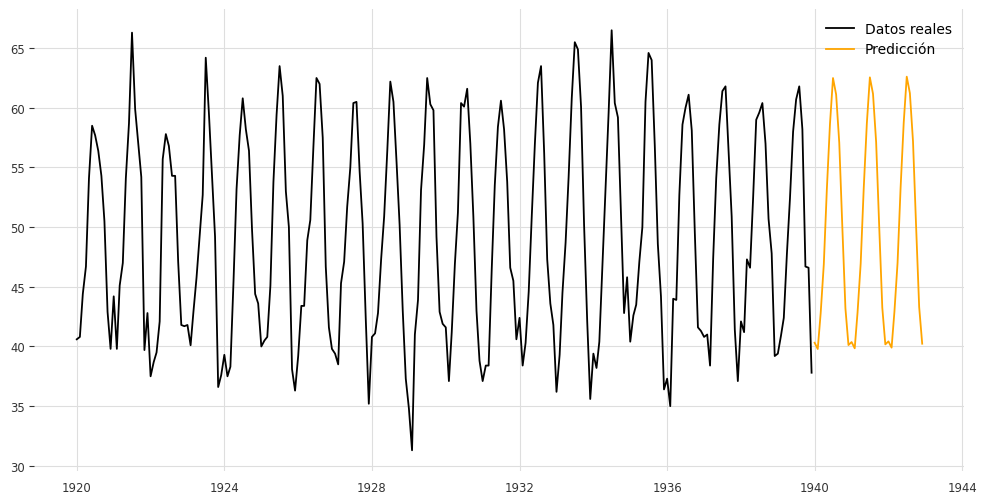

In [12]:
datos = pd.read_csv('./data/monthly-mean-temp.csv', delimiter=",")

datos['Month'] = pd.to_datetime(datos['Month'], format='%Y-%m')
datos['Temperature'] = datos['Temperature'].astype(float)

# Ajusta el modelo de suavización exponencial
modelo = ExponentialSmoothing(datos['Temperature'], trend='add', seasonal='add', seasonal_periods=12)
modelo_fit = modelo.fit()

# Realiza predicciones
prediccion = modelo_fit.forecast(steps=36)  # Ajusta el número de pasos según tus necesidades

# Visualiza los datos y las predicciones
plt.figure(figsize=(12, 6))
plt.plot(datos['Month'], datos['Temperature'], label='Datos reales')
plt.plot(pd.date_range(start=datos['Month'].max(), periods=36, freq='M'), prediccion, label='Predicción', color='orange')
plt.legend()
plt.show()

### Prophet

In [25]:
def evaluar_prediccion(series, frecuencia = "M"):
    datos = series
    n_entreno = int(len(datos) * 0.8) # porcentaje usado para entreno
    long_max = len(datos) - n_entreno
    print(f"Tamaño entreno {n_entreno} ")
    print(f"Tamaño prueba {long_max} ")
    lista_cfg = [1]
    entreno, prueba = division_entreno_prueba(datos, n_entreno)
    modelo = Prophet(mcmc_samples = 500, seasonality_mode = 'multiplicative').fit(series);
    futuro = modelo.make_future_dataframe(periods = len(prueba),freq = frecuencia)
    predicciones = modelo.predict(futuro)
    modelo.plot(predicciones)
    rmse = medir_rmse(predicciones.iloc[len(entreno):len(series)]["yhat"], prueba["y"])
   
    return rmse

def parse_date (x): 
    return datetime.datetime.strptime("0"+str(x), '%y-%m') 

*SHAMPOO*

Tamaño entreno 28 
Tamaño prueba 8 


08:03:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

08:03:26 - cmdstanpy - INFO - CmdStan done processing.
08:03:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!


08:03:26 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 3 divergent transitions (1.2%)
	Chain 3 had 1 divergent transitions (0.4%)
	Chain 4 had 9 divergent transitions (3.6%)
	Use function "diagnose()" to see further information.
08:03:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

08:03:55 - cmdstanpy - INFO - CmdStan done processing.
08:03:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if

08:03:56 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 2 divergent transitions (0.8%)
	Use function "diagnose()" to see further information.


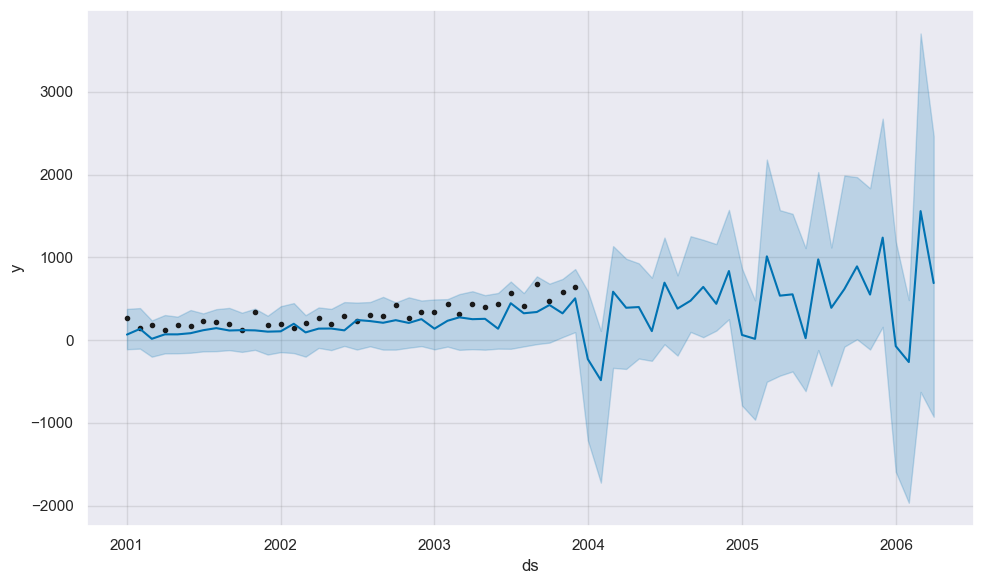

In [41]:
series = pd.read_csv('./data/shampoo.csv', header=0)
series['ds']  = series['Month'].apply(lambda x: parse_date(x))
series[['y']] = series[['Sales']].astype(float)
series = series[["ds","y"]]
rmse_SHAMPOO = evaluar_prediccion(series)

modelo = Prophet(mcmc_samples = 500, seasonality_mode = 'multiplicative').fit(series);

*Monthly-mean-temp*

03:11:48 - cmdstanpy - INFO - CmdStan start processing


Tamaño entreno 192 
Tamaño prueba 48 


chain 1 |          | 00:00 Status





chain 1 |██▊       | 00:01 Iteration:   1 / 500 [  0%]  (Warmup)


chain 1 |████▎     | 00:03 Iteration: 100 / 500 [ 20%]  (Warmup)


chain 1 |█████▋    | 00:03 Iteration: 200 / 500 [ 40%]  (Warmup)


chain 1 |███████▏  | 00:05 Iteration: 251 / 500 [ 50%]  (Sampling)



chain 1 |████████▌ | 00:06 Iteration: 350 / 500 [ 70%]  (Sampling)

chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


03:11:56 - cmdstanpy - INFO - CmdStan done processing.
03:11:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/Users/runner/work/prophet/prophet/python/build/lib.macosx-10.9-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/Users/runner/work/prophet/prophet/python/build/lib.macosx-10.9-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in '/Users/runner/work/prophet/prophet/python/build/lib.macosx-10.9-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/Users/run

03:11:58 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▊       | 00:01 Iteration:   1 / 500 [  0%]  (Warmup)


chain 1 |████▎     | 00:02 Iteration: 100 / 500 [ 20%]  (Warmup)


chain 1 |█████▋    | 00:03 Iteration: 200 / 500 [ 40%]  (Warmup)


chain 1 |███████▏  | 00:05 Iteration: 251 / 500 [ 50%]  (Sampling)



chain 1 |████████▌ | 00:06 Iteration: 350 / 500 [ 70%]  (Sampling)


chain 1 |██████████| 00:07 Iteration: 450 / 500 [ 90%]  (Sampling)

chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


03:12:05 - cmdstanpy - INFO - CmdStan done processing.
03:12:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/Users/runner/work/prophet/prophet/python/build/lib.macosx-10.9-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/Users/runner/work/prophet/prophet/python/build/lib.macosx-10.9-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in '/Users/runner/work/prophet/prophet/python/build/lib.macosx-10.9-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/Users/run

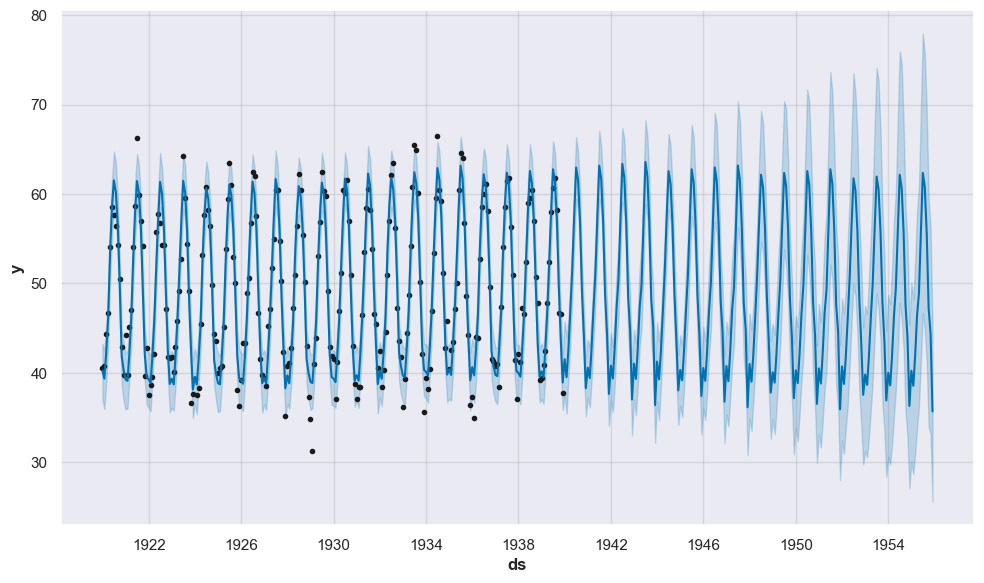

In [13]:
from datetime import datetime

# Define una función para parsear la fecha
def parse_date(date_str):
    return datetime.strptime(date_str, '%Y-%m')

# Lee los datos desde un archivo CSV y realiza las conversiones de tipo
series_month = pd.read_csv('./data/monthly-mean-temp.csv', header=0)
series_month['ds'] = series_month['Month'].apply(lambda x: parse_date(x))
series_month[['y']] = series_month[['Temperature']].astype(float)
series_month = series_month[["ds", "y"]]

rmse_MONTHMEAN = evaluar_prediccion(series_month)

modelo = Prophet(mcmc_samples = 500, seasonality_mode = 'multiplicative').fit(series_month);

*Monthly-car-sales*

03:19:56 - cmdstanpy - INFO - CmdStan start processing


Tamaño entreno 86 
Tamaño prueba 22 


chain 1 |          | 00:00 Status



chain 1 |██▊       | 00:01 Iteration:   1 / 500 [  0%]  (Warmup)




chain 1 |████▎     | 00:02 Iteration: 100 / 500 [ 20%]  (Warmup)


chain 1 |███████▏  | 00:03 Iteration: 251 / 500 [ 50%]  (Sampling)


chain 1 |████████▌ | 00:03 Iteration: 350 / 500 [ 70%]  (Sampling)


chain 1 |██████████| 00:03 Iteration: 450 / 500 [ 90%]  (Sampling)


chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


03:20:00 - cmdstanpy - INFO - CmdStan done processing.
03:20:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/Users/runner/work/prophet/prophet/python/build/lib.macosx-10.9-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/Users/runner/work/prophet/prophet/python/build/lib.macosx-10.9-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/Users/runner/work/prophet/prophet/python/build/lib.macosx-10.9-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in '/Users/runn

03:20:03 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▍        | 00:00 Status




chain 1 |██▊       | 00:01 Iteration:   1 / 500 [  0%]  (Warmup)
chain 1 |████▎     | 00:02 Iteration: 100 / 500 [ 20%]  (Warmup)


chain 1 |█████▋    | 00:02 Iteration: 200 / 500 [ 40%]  (Warmup)





chain 1 |███████▏  | 00:03 Iteration: 251 / 500 [ 50%]  (Sampling)


chain 1 |████████▌ | 00:03 Iteration: 350 / 500 [ 70%]  (Sampling)

chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


03:20:07 - cmdstanpy - INFO - CmdStan done processing.
03:20:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/Users/runner/work/prophet/prophet/python/build/lib.macosx-10.9-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/Users/runner/work/prophet/prophet/python/build/lib.macosx-10.9-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/Users/runner/work/prophet/prophet/python/build/lib.macosx-10.9-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!


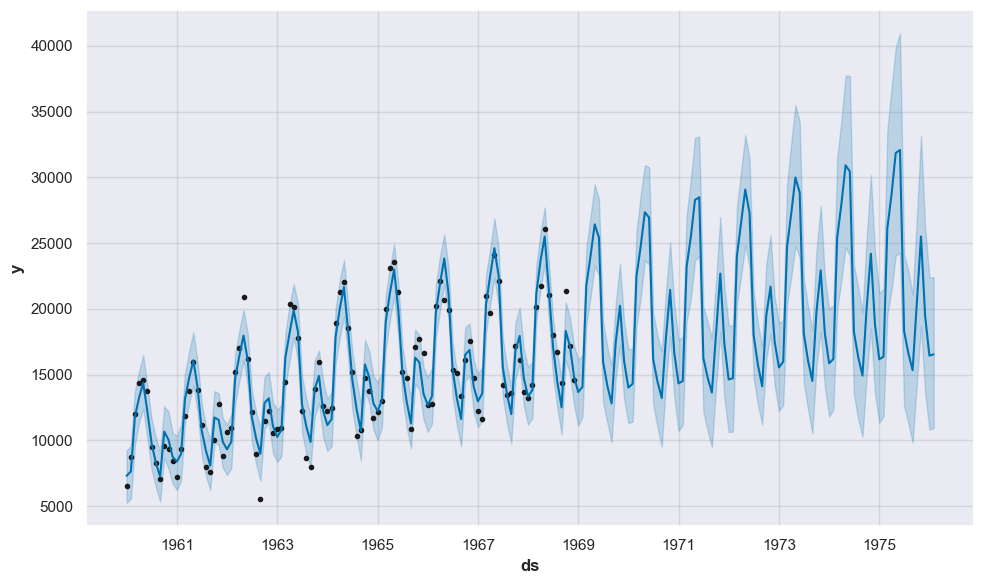

In [23]:
series_mcs = pd.read_csv('./data/monthly-car-sales.csv', header=0)
series_mcs['ds']  = series_mcs['Month'].apply(lambda x: parse_date(x))
series_mcs[['y']] = series_mcs[['Sales']].astype(float)
series_mcs = series_mcs[["ds","y"]]
rmse_mcs = evaluar_prediccion(series_mcs)

modelo = Prophet(mcmc_samples = 500, seasonality_mode = 'multiplicative').fit(series_mcs);

*Daily-total-female-births*

Tamaño entreno 292 
Tamaño prueba 73 


07:54:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

07:54:22 - cmdstanpy - INFO - CmdStan done processing.
07:54:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_

07:54:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

07:54:44 - cmdstanpy - INFO - CmdStan done processing.
07:54:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: 

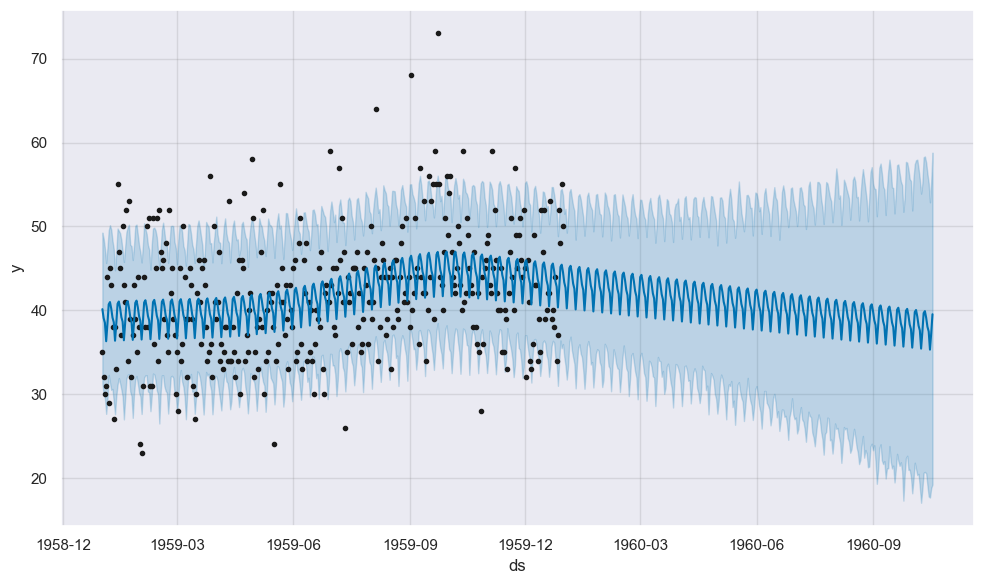

In [28]:
series_nac_fem = pd.read_csv('./data/daily-total-female-births.csv', header=0, index_col=None)
series_nac_fem['ds']  = pd.to_datetime(series_nac_fem['Date'])
series_nac_fem[['y']] = series_nac_fem[['Births']].astype(float)
series_nac_fem = series_nac_fem[["ds","y"]]
rmse_nac_fem = evaluar_prediccion(series_nac_fem, "D")

modelo = Prophet(mcmc_samples = 500, seasonality_mode = 'multiplicative').fit(series_nac_fem);

### Redes Neuronales

In [31]:
def division_entreno_prueba(datos, n_prueba):
    return datos[:-n_prueba], datos[-n_prueba:]

def series_a_supervisado(datos, n_entrada, n_salida = 1):
    df = DataFrame(datos)
    cols = []
	# secuencia de entrada (t-n, ... t-1)
    for i in range(n_entrada, 0, -1):
	    cols.append(df.shift(i))
    # secuencia predicha (t, t+1, ... t+n)
    for i in range (0, n_salida):
	    cols.append(df.shift(-i))
    # juntarlo todo
    agg = concat(cols, axis = 1)
	# botar columnas con valores NaN
    agg.dropna(inplace = True)
    return agg.values

def medir_rmse(actual, predicho):
    return sqrt(mean_squared_error(actual, predicho))

def ajustar_modelo(entreno, config):
	# desempacar la configuración
	n_entrada, n_nodos, n_epocas, n_tandas = config
    #[24, 500, 100, 100]
    # preparar los datos
	datos = series_a_supervisado(entreno, n_entrada)
	entreno_x, entreno_y = datos[:, :-1], datos[:, -1]
	# definir el modelo
	modelo = tf.keras.Sequential()
	modelo.add(tf.keras.layers.Dense(n_nodos, activation='relu', input_dim = n_entrada))
	modelo.add(tf.keras.layers.Dense(1))
	modelo.compile(loss='mse', optimizer='adam')
	# ajustar
	modelo.fit(entreno_x, entreno_y, epochs = n_epocas, batch_size = n_tandas, verbose = 0)
	return modelo

def prediccion_modelo(modelo, historia, config):
    	# desempacar la configuración
	n_entrada, _, _, _ = config
	# preparar los datos
	x_entrada = array(historia[-n_entrada:]).reshape(1, n_entrada)
	# predecir
	yhat = modelo.predict(x_entrada, verbose = 0)
	return yhat[0]

def validacion_al_frente(datos, n_prueba, cfg):
    predicciones = []
    # dividir el conjunto de datos
    entreno, prueba = division_entreno_prueba(datos, n_prueba)
    # ajustar el modelo
    modelo = ajustar_modelo(entreno, cfg)
    # grabar la historia con el conjunto de datos de entrenamiento
    historia = [x for x in entreno]
    # pasar por cada incremento de tiempo en el conjunto de prueba
    for i in range(len(prueba)):
        # ajustar el modelo a los datos y predecir los datos históricos
        yhat = prediccion_modelo(modelo, historia, cfg)
        # agregar el dato predicho en la lista de preducciones
        predicciones.append(yhat)
        # agregar la observación a la historia para la siguiente iteración
        historia.append(prueba[i])
    # estimar el error de las predicciones
    error = medir_rmse(prueba, predicciones)
    print(f' > {error:.3f}')
    return [error, predicciones]

def evaluacion_iter(datos, config, n_prueba, n_repeticiones = 5):
    	# ajustar y evaluar el modelo n veces
    resultados = []
    predicciones = []
    for _ in range(n_repeticiones):
        resultados_temp, predicciones_temp = validacion_al_frente(datos, n_prueba, config)
        resultados.append(resultados_temp)
        predicciones.append(predicciones_temp)
    return [resultados, predicciones]
      
def buscar_mejor_solucion(series, nombre, metodo = "red neuronal"):
    datos = series.values
    n_prueba = int(len(datos)*0.2) # porcentaje utilizado para prueba
    config = [24, 500, 100, 100]
    resultados, predicciones = evaluacion_iter(datos, config, n_prueba)
    plt.savefig("resultados_{nombre}_{metodo}.png")
    plt.show()
    entreno, prueba = division_entreno_prueba(datos,n_prueba)
    prediccion = pd.DataFrame(list(entreno.flatten()) + np.array(predicciones[0]).flatten().tolist())
    ax = pd.DataFrame(datos).plot(label="Original") # datos originales
    prediccion.plot(ax=ax, alpha=.7, figsize=(14,7))
    plt.savefig("pred_{nombre}_{metodo}.png")
    plt.show()
    return resultados

*SHAMPOO*

 > 114.732
 > 104.388
 > 104.744
 > 106.258
 > 105.968


<Figure size 640x480 with 0 Axes>

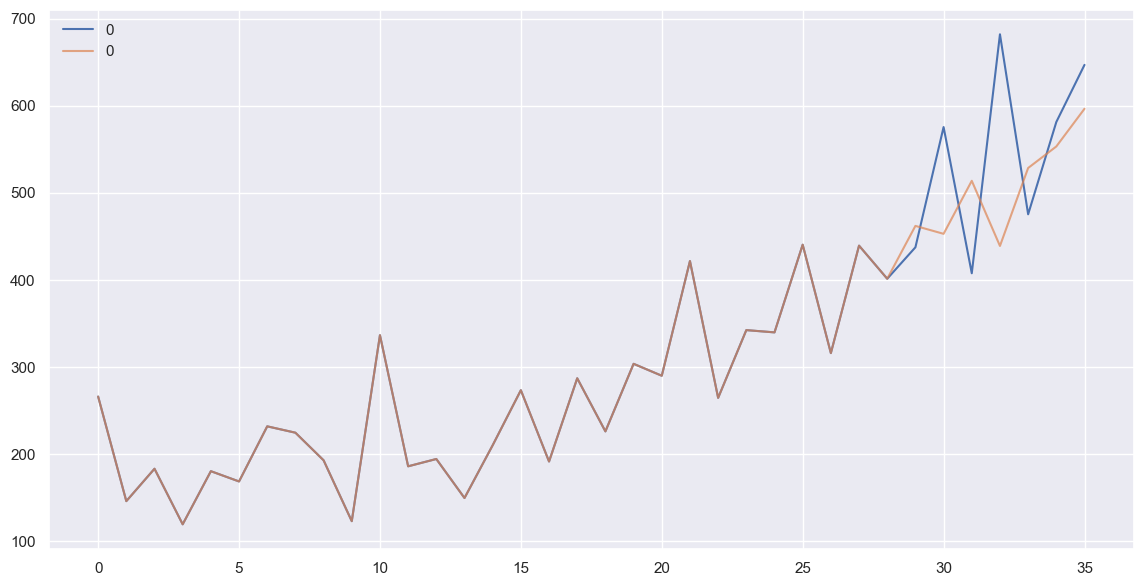

In [42]:
series = pd.read_csv('./data/shampoo.csv', header=0, index_col=0)
r_shampoo = buscar_mejor_solucion(series,"shampoo")

*Monthly-mean-temp*


 > 2.144
 > 2.240
 > 2.216
 > 2.338
 > 2.211


<Figure size 640x480 with 0 Axes>

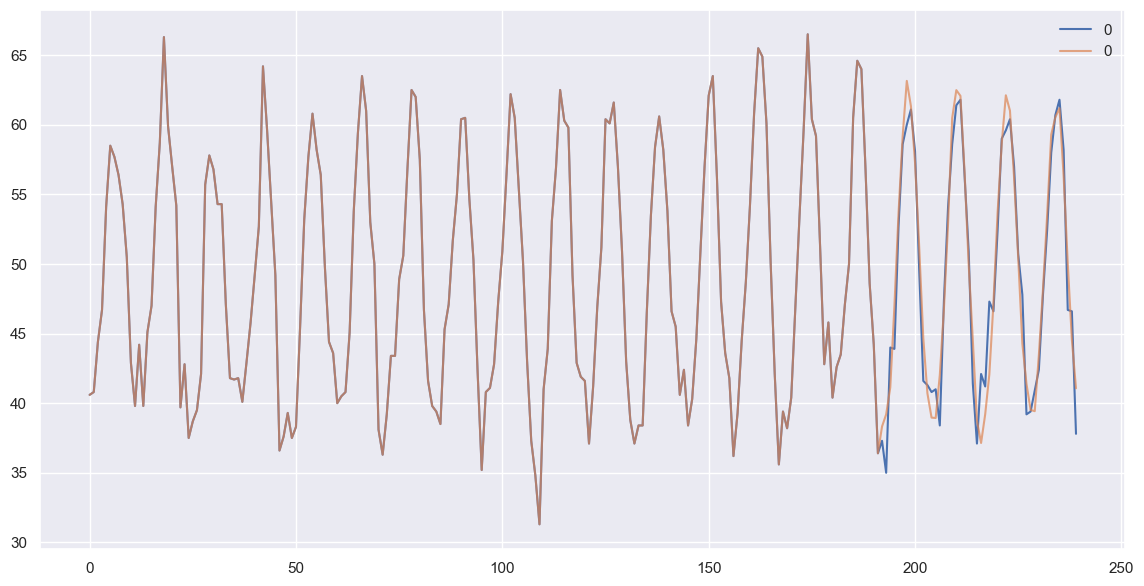

In [16]:
series_month = pd.read_csv('./data/monthly-mean-temp.csv', header=0, index_col=0)
r_mont_mean = buscar_mejor_solucion(series_month,"monthly-mean-temp")

*Monthly-car-sales*

 > 2052.655
 > 2066.581
 > 1936.353
 > 1933.197
 > 2145.511


<Figure size 640x480 with 0 Axes>

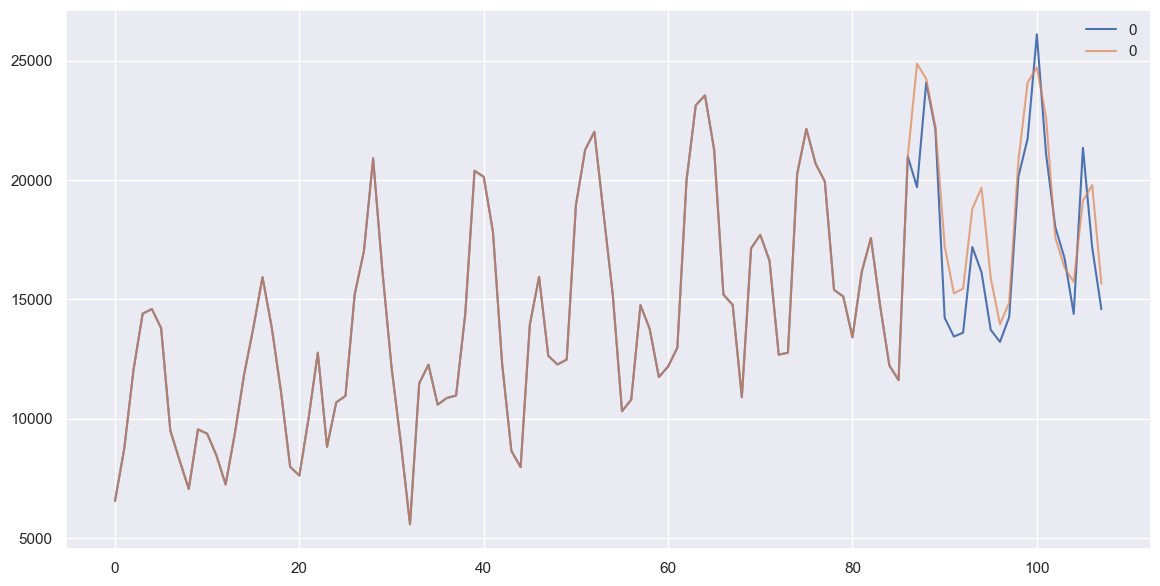

In [24]:
series_month_car = pd.read_csv('./data/monthly-car-sales.csv', header=0, index_col=0)
r_month_car = buscar_mejor_solucion(series_month_car,"monthly-mean-temp")

*Daily-total-female-births*

 > 6.675
 > 6.524
 > 6.852
 > 6.838
 > 6.820


<Figure size 640x480 with 0 Axes>

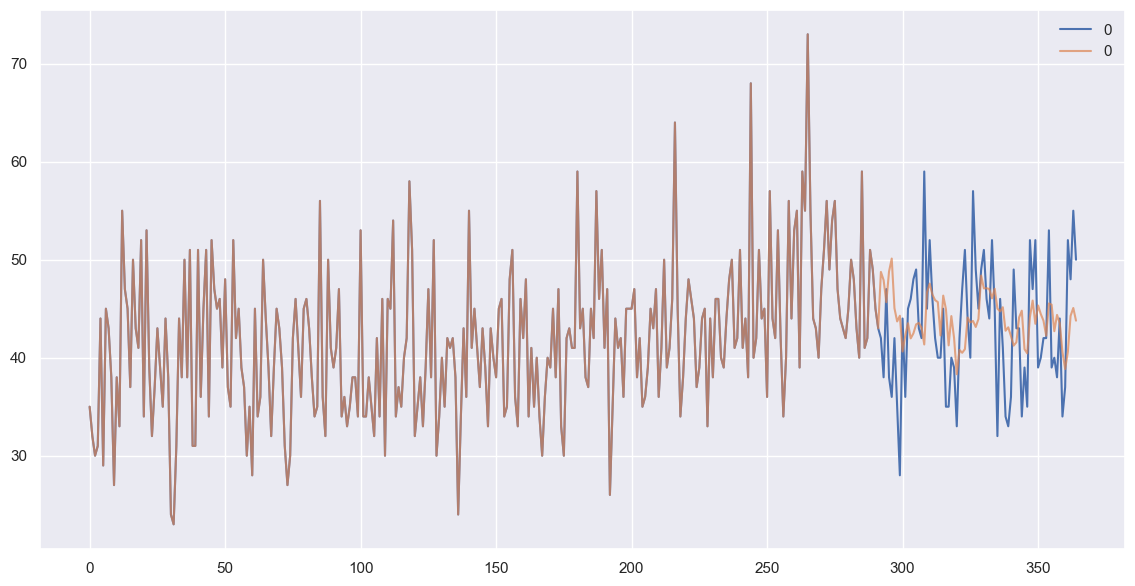

In [32]:
series_nac_fem = pd.read_csv('./data/daily-total-female-births.csv', header=0, index_col=0)
r_nac_fen = buscar_mejor_solucion(series_nac_fem,"nac-fem")

### Comparación y Evaluación

In [33]:
def resumir_resultados(nombre, resultados):
    	# imprimir un resúmen
	media_result, std_result = mean(resultados), std(resultados)
	print(f'{nombre}: {media_result:.3f} RMSE (+/- {std_result:.3f})')
	# gráficas de caja y bigotes
	pyplot.boxplot(resultados)
	pyplot.show()
	return std_result

*SHAMPOO*

Prophet
RMSE: 151.91248574476464
Redes Neuronales
mlp: 107.218 RMSE (+/- 3.823)


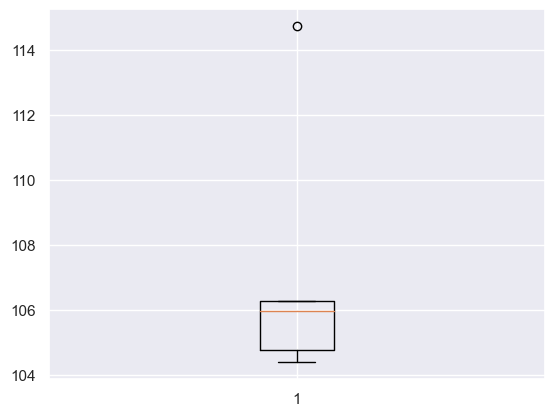

RMSE: 3.8228180761932116
Promedio
RMSE: 0
SARIMA
RMSE: 0


In [44]:
print("Prophet")
print(f"RMSE: {rmse_SHAMPOO}")

print("Redes Neuronales")
rsme_red_SHAMPOO = resumir_resultados('mlp', r_shampoo)
print(f"RMSE: {rsme_red_SHAMPOO}")

print("Promedio")
print(f"RMSE: {rsme_pro_shampo}")
    
print("SARIMA")
print(f"RMSE: {rsme_sar_shampoo}")

*Monthly-mean-temp*

Prophet
RMSE: 2.0237188779692485
Redes Neuronales
mlp: 2.230 RMSE (+/- 0.063)


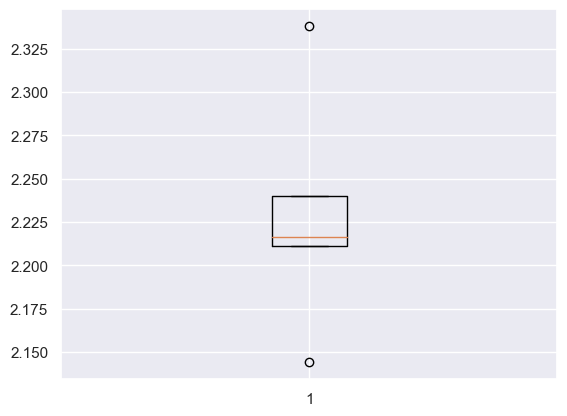

RMSE: 0.0627879479761298
Promedio
RMSE: 0
SARIMA
RMSE: 0


In [19]:
print("Prophet")
print(f"RMSE: {rmse_MONTHMEAN}")

print("Redes Neuronales")
rsme_red_month_mean = resumir_resultados('mlp', r_mont_mean)
print(f"RMSE: {rsme_red_month_mean}")

print("Promedio")
print(f"RMSE: {rsme_pro_mmt}")
    
print("SARIMA")
print(f"RMSE: {rsme_sar_mmt}")

*Monthly-car-sales*

Prophet
RMSE: 1337.0998121947434
Redes Neuronales
mlp: 2026.859 RMSE (+/- 81.591)


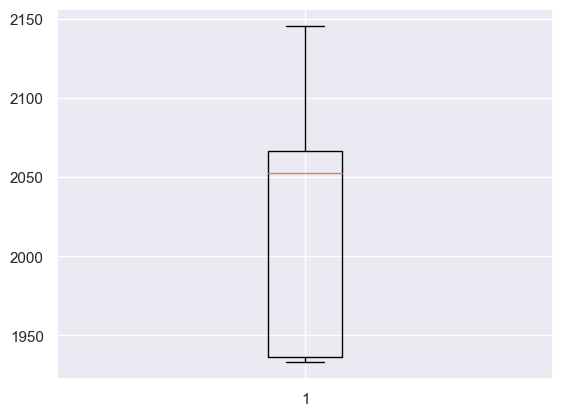

RMSE: 81.59094816803373
Promedio
RMSE: 0
SARIMA
RMSE: 0


In [25]:
print("Prophet")
print(f"RMSE: {rmse_mcs}")

print("Redes Neuronales")
rsme_red_month_car = resumir_resultados('mlp', r_month_car)
print(f"RMSE: {rsme_red_month_car}")

print("Promedio")
print(f"RMSE: {rsme_pro_mcs}")
    
print("SARIMA")
print(f"RMSE: {rsme_sar_mcs}")

*Daily-total-female-births*

Prophet
RMSE: 6.647156189694226
Redes Neuronales
mlp: 6.742 RMSE (+/- 0.126)


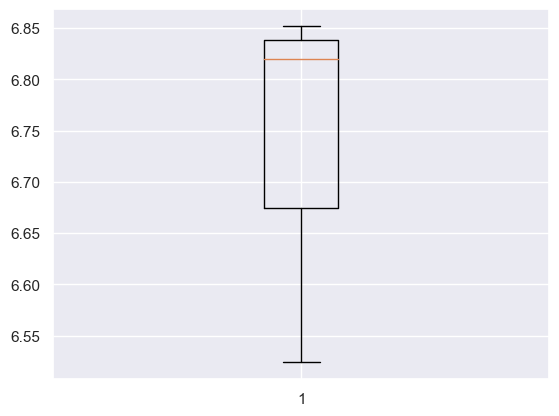

RMSE: 0.1259240606135922
Promedio
RMSE: 0
SARIMA
RMSE: 0


In [36]:
print("Prophet")
print(f"RMSE: {rmse_nac_fem}")

print("Redes Neuronales")
rsme_red_nac_fem = resumir_resultados('mlp', r_nac_fen)
print(f"RMSE: {rsme_red_nac_fem}")

print("Promedio")
print(f"RMSE: {rsme_pro_nac_fem}")
    
print("SARIMA")
print(f"RMSE: {rsme_sar_nac_fem}")